# RL Lab 3: Policy Iteration

基于策略迭代的网格迷宫求解。

## 简介

动态规划适合于解决状态转移过程完全已知的最优决策问题。策略迭代算法通过策略评估和策略提升两个步骤来迭代地改进策略。策略评估的目标是计算当前策略下的状态价值函数$V(s)$，而策略提升则是通过贪心选择来更新策略。

## 目标

- 在`GridWorldEnvironment`的基础上实现策略迭代算法。
- 通过可视化方法显示算法的收敛过程、状态价值函数和策略。

### 扩展

* 策略迭代算法能否避免陷入局部策略循环？
* 贴现因子$\gamma$对模型收敛过程存在什么影响？

In [1]:
import torch
import random
from matplotlib import pyplot as plt
from rl_env import GridEnvironment

%config InlineBackend.figure_format = 'svg'

# seed = random.randint(0, 10000)
seed = 7080
print(f"Seed: {seed}")
torch.manual_seed(seed)
random.seed(seed)

Seed: 7080


生成迷宫

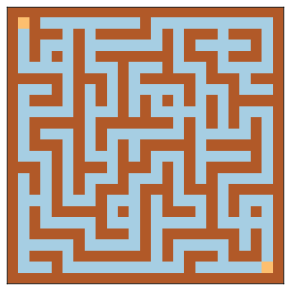

In [2]:
env = GridEnvironment(25, 25, wall_ratio=0.07)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

grid_to_show = 2 * env.grid.clone().cpu().numpy()
grid_to_show[*env.starting_state] = 1
grid_to_show[*env.ending_state] = 1

ax.imshow(grid_to_show, cmap='Paired', interpolation='nearest')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_aspect(env.ncols / env.nrows)

plt.show()

实现智能体。智能体需要维护状态-价值函数。

In [3]:
class PolicyIterationAgent():
    def __init__(self, env, discount_factor=0.9, eps=1e-6):
        self.env = env
        self.eps = eps
        self.discount_factor = discount_factor

        self.state_values = torch.zeros(env.num_states, dtype=torch.float32, device=env.device)
        self.policy = torch.zeros(env.num_states, dtype=torch.long, device=env.device)

    @property
    def action_values(self):
        # Q^*(s, a) &= R(s, a) + \gamma \sum_{s'} P(s'|s, a)V^*(s')
        return (
            self.discount_factor * self.env.state_transition_np * self.state_values + \
            self.env.step_reward_np
        ) \
            .sum(axis=1) \
            .to_dense() \
            .reshape(self.env.num_states, self.env.num_actions)

    def step(self) -> float:
        self.state_values = self.action_values[torch.arange(self.env.num_states), self.policy]

        # Prevent state loops by adding noise
        self.state_values += torch.randn(self.env.num_states, device=self.env.device) * self.eps

        new_policy = self.action_values.argmax(axis=1)

        # Check for convergence
        delta = (new_policy != self.policy).sum().item()

        self.policy = new_policy
        return delta

    def __iter__(self):
        return self

    def __next__(self):
        delta = self.step()
        if not delta:
            raise StopIteration
        return delta


agent = PolicyIterationAgent(env, discount_factor=0.99, eps=1e-6)
deltas = [*agent]

显示策略更新过程。

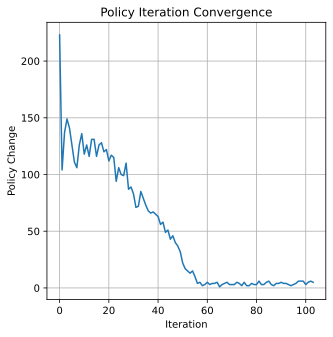

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(deltas)
ax.set_xlabel('Iteration')
ax.set_ylabel('Policy Change')
ax.set_title('Policy Iteration Convergence')
ax.grid()
plt.show()

显示状态值和策略

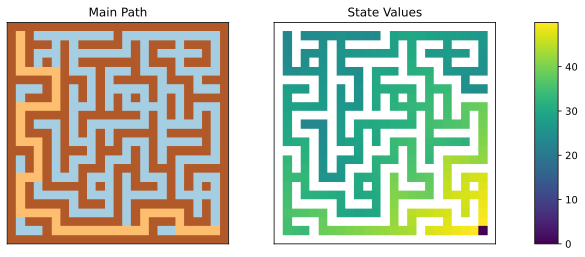

In [5]:
fig, (ax_path, ax_state, ax_cmap) = plt.subplots(1, 3, figsize=(10, 4), width_ratios=[1, 1, 0.1])

ax_path.set_title('Main Path')
state = env.starting_state
path = [state]
for _ in range(100):
    if state == env.ending_state:
        break
    action = agent.policy[env.get_state(state)].item()
    next_state = state + env.get_action(action)
    path.append(next_state)
    state = next_state
path_grid = grid_to_show.copy()
for index, (i, j) in enumerate(path):
    path_grid[i, j] = 1
ax_path.imshow(path_grid, cmap='Paired')

ax_state.set_title('State Values')
state_values_to_show = torch.full((env.nrows, env.ncols), torch.nan)
for i, value in enumerate(agent.state_values):
    state = env.get_state(i)
    state_values_to_show[*state] = value.item()
ax_state.imshow(state_values_to_show.cpu().numpy(), cmap='viridis', interpolation='nearest')
fig.colorbar(ax_state.images[0], cax=ax_cmap, orientation='vertical')

for ax in (ax_path, ax_state):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect(env.ncols / env.nrows)

plt.show()